In [1]:
import networkx as nx
import numpy as np
from numpy import radians as rad

import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import cm
import matplotlib.lines as lines 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.stats as ss
from scipy.io import mmread

import seaborn as sns
import pandas as pd

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# ref: https://matplotlib.org/gallery/api/font_family_rc_sgskip.html
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams["mathtext.fontset"] = 'dejavusans'

In [2]:
def no_right_top(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
def no_border(ax):
    for pos in ['top', 'right', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)

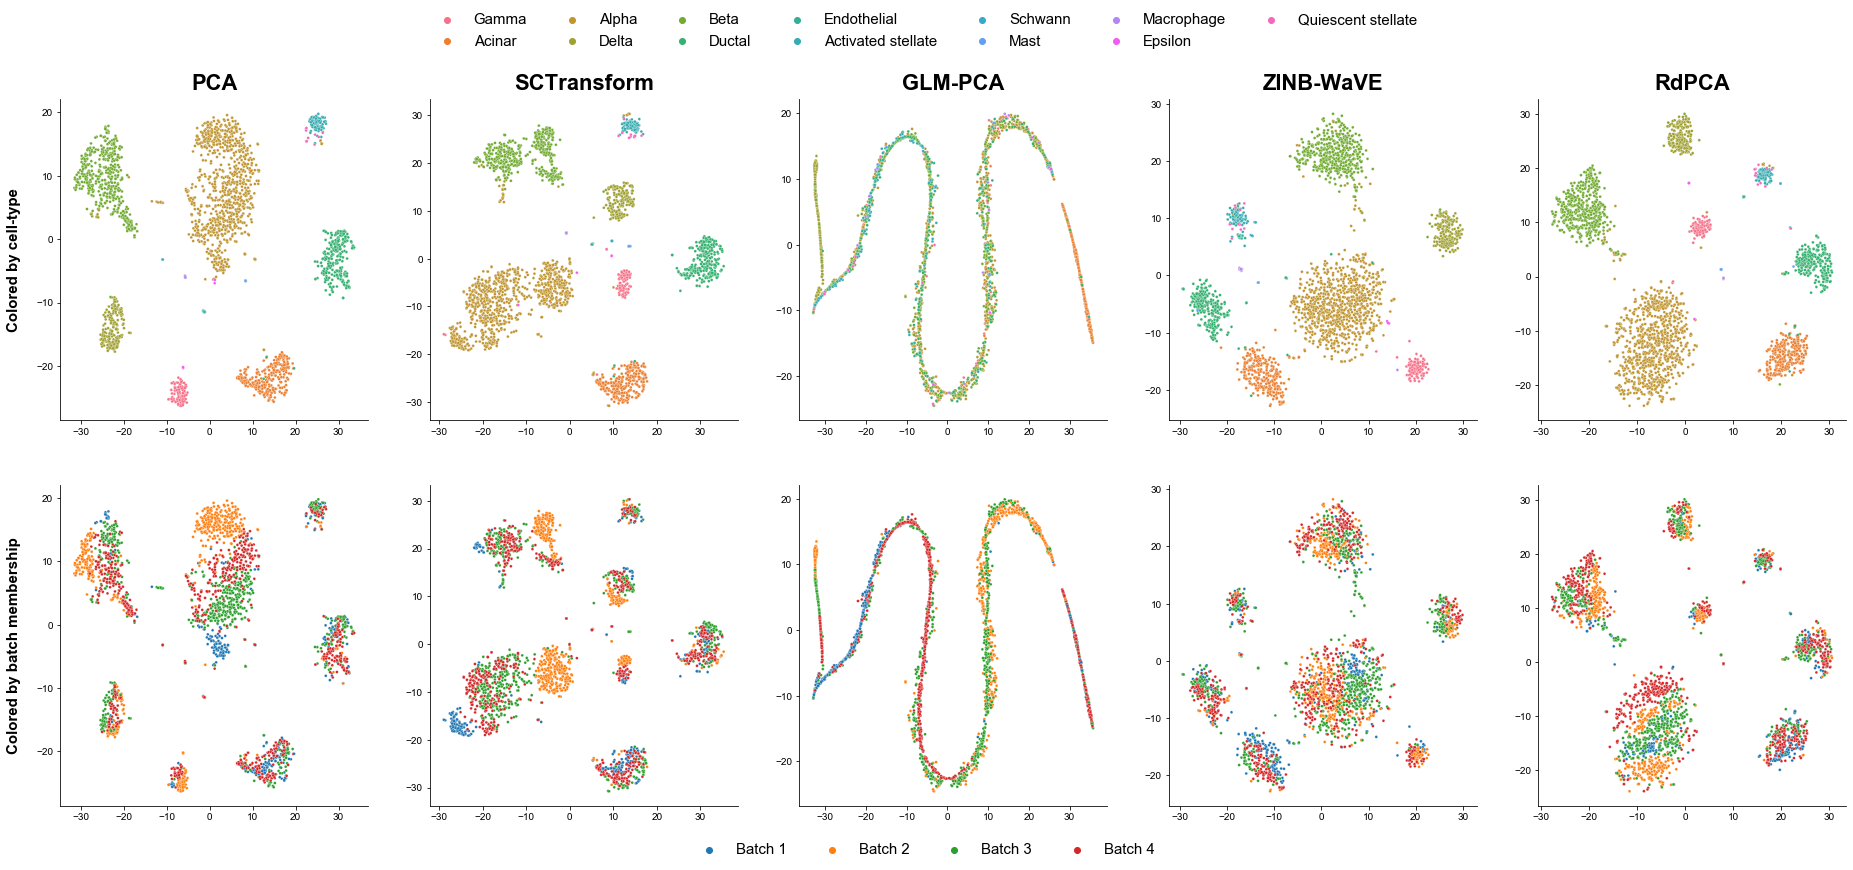

In [4]:
fig, axes = plt.subplots(2,5, figsize=(32,13))
filenames = ['muraro/tsne_pca.csv', 
            'muraro/tsne_sct.csv',
            'muraro/tsne_glmpca.csv',
            'muraro/tsne_zinbwave.csv',
            'muraro/tsne_rdpca.csv',]
dfs = [pd.read_csv(filename, index_col=0) for filename in filenames]
meta = pd.read_csv('../data/muraro/meta.csv', index_col=0)
for df in dfs:
    df['celltype'] = meta.celltype.values
    df['batch'] = [x.split('-')[0] for x in meta.index]
names = ['PCA', 'SCTransform', 'GLM-PCA', 'ZINB-WaVE', 'RdPCA']
legends = [True, False, False, False, False]

for i in range(5):
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=dfs[i], hue='celltype', legend=legends[i], ax=axes[0,i], s=8)
    no_right_top(axes[0,i])
    axes[0,i].set_title(names[i], fontsize=22, fontweight='bold', va='bottom')

for i in range(5):
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=dfs[i], hue='batch', legend=legends[i], ax=axes[1,i], s=8)
    no_right_top(axes[1,i])

handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,0].legend(bbox_to_anchor=(0.5, 0.92), loc='lower center', bbox_transform=fig.transFigure, ncol=7, fontsize=15, frameon=False,
                handles=handles,
                labels=[
                    'Gamma', 'Acinar', 'Alpha', 'Delta', 'Beta', 'Ductal', 'Endothelial', 'Activated stellate', 'Schwann',
                    'Mast', 'Macrophage', 'Epsilon', 'Quiescent stellate'
                ])
handles, labels = axes[1,0].get_legend_handles_labels()
axes[1,0].legend(bbox_to_anchor=(0.5, 0.1), loc='upper center', bbox_transform=fig.transFigure, ncol=4, fontsize=15, frameon=False,
                handles=handles, labels=['Batch %d' % (d+1) for d in range(4)])
fig.text(-0.15, 0.5, 'Colored by cell-type', transform=axes[0,0].transAxes, rotation=90, ha='center', va='center', fontsize=15, fontweight='bold')
fig.text(-0.15, 0.5, 'Colored by batch membership', transform=axes[1,0].transAxes, rotation=90, ha='center', va='center', fontsize=15, fontweight='bold')
"""

"""
plt.show()

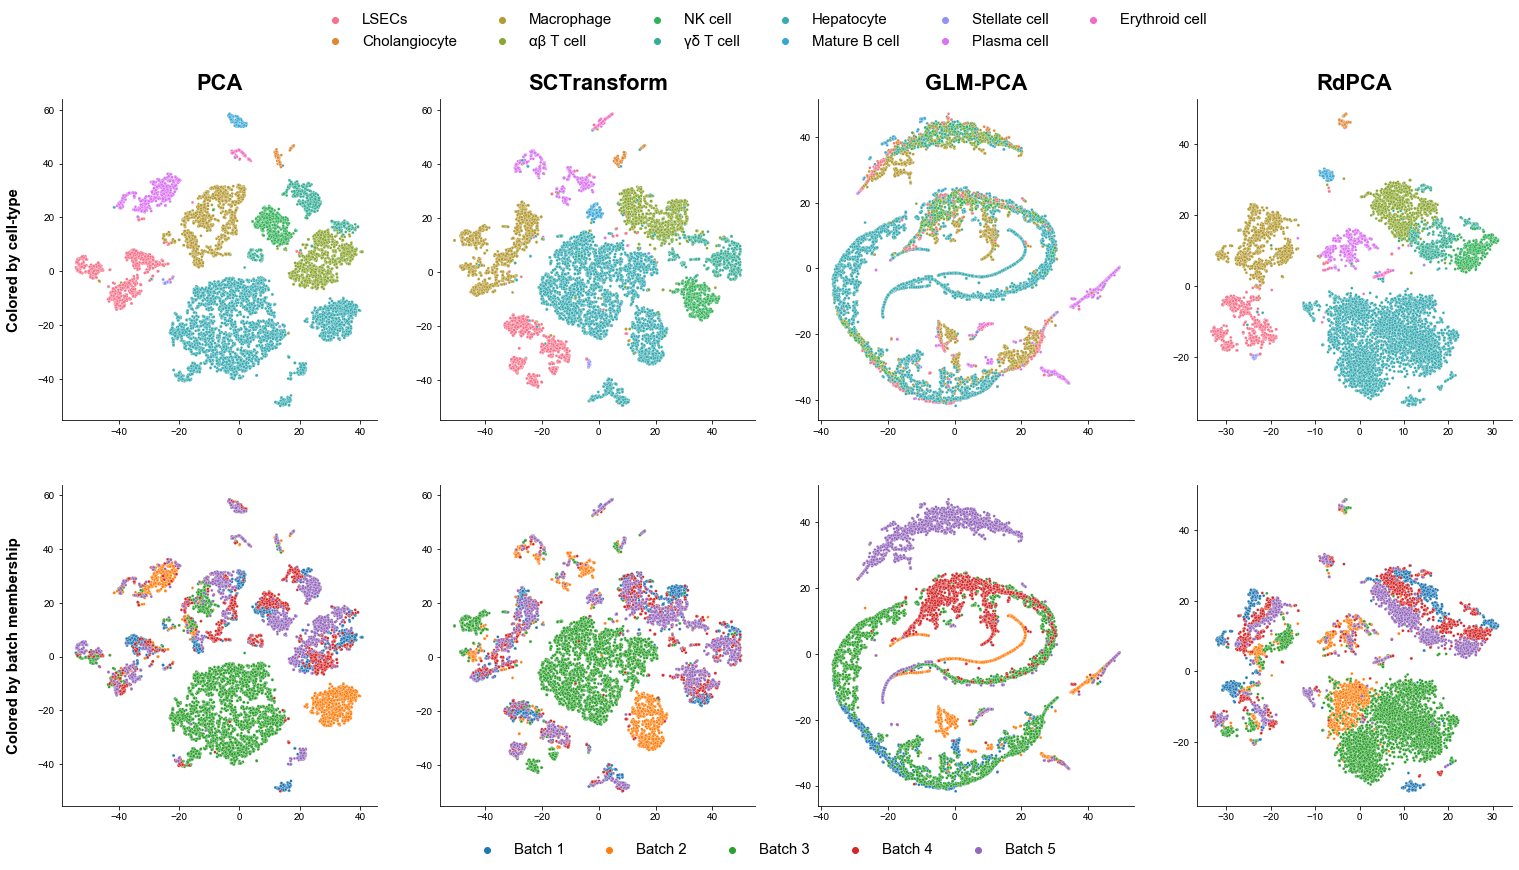

In [8]:
fig, axes = plt.subplots(2,4, figsize=(26,13))
filenames = ['/data01/hanbin973/liver/tsne_pca.csv', 
            '/data01/hanbin973/liver/tsne_sct.csv',
            '/data01/hanbin973/liver/tsne_glmpca.csv',
            '/data01/hanbin973/liver/tsne_rdpca.csv',]
dfs = [pd.read_csv(filename, index_col=0) for filename in filenames]
meta = pd.read_csv('../data/macparland/meta.csv', index_col=0)
for df in dfs:
    df['celltype'] = meta.celltype.values
    df['batch'] = meta['orig.ident']
names = ['PCA', 'SCTransform', 'GLM-PCA', 'RdPCA']
legends = [True, False, False, False]

for i in range(4):
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=dfs[i], hue='celltype', legend=legends[i], ax=axes[0,i], s=8)
    no_right_top(axes[0,i])
    axes[0,i].set_title(names[i], fontsize=22, fontweight='bold', va='bottom')

for i in range(4):
    sns.scatterplot(x='tSNE_1', y='tSNE_2', data=dfs[i], hue='batch', legend=legends[i], ax=axes[1,i], s=8)
    no_right_top(axes[1,i])
      
handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,0].legend(bbox_to_anchor=(0.5, 0.92), loc='lower center', bbox_transform=fig.transFigure, ncol=6, fontsize=15, frameon=False,
                handles=handles,
                labels=[
                    'LSECs', 'Cholangiocyte', 'Macrophage', 'αβ T cell', 'NK cell', 'γδ T cell', 'Hepatocyte',
                    'Mature B cell', 'Stellate cell', 'Plasma cell', 'Erythroid cell'
                ])
handles, labels = axes[1,0].get_legend_handles_labels()
axes[1,0].legend(bbox_to_anchor=(0.5, 0.1), loc='upper center', bbox_transform=fig.transFigure, ncol=5, fontsize=15, frameon=False,
                handles=handles, labels=['Batch %d' % (d+1) for d in range(5)])
fig.text(-0.15, 0.5, 'Colored by cell-type', transform=axes[0,0].transAxes, rotation=90, ha='center', va='center', fontsize=15, fontweight='bold')
fig.text(-0.15, 0.5, 'Colored by batch membership', transform=axes[1,0].transAxes, rotation=90, ha='center', va='center', fontsize=15, fontweight='bold')
plt.show()

# Lower panel

In [10]:
def confounder_plot(ax):
    graph = nx.DiGraph()
    pos = {'Cell-type':(-0.4,0), 'Expression':(0.4,-0.4), 'Batch':(0,0.5)}
    graph.add_edges_from([('Batch', 'Cell-type'), 
                         ('Batch', 'Expression'),
                         ('Cell-type', 'Expression')
                         ])

    # draw graph
    nx.draw_networkx_nodes(graph, 
                           pos=pos, node_color=['red','black','black'], node_size=1000,
                           ax=ax, alpha=0)
    nx.draw_networkx_edges(graph, pos, alpha=1, width=2,
                          min_source_margin=35,
                          min_target_margin=35, 
                        ax=ax)
    nx.draw_networkx_labels(graph, pos, ax=ax,bbox=dict(facecolor='none', edgecolor='black', boxstyle='round, pad=0.3, rounding_size=0.1'),
                           font_size=20)

    # adjust margin
    ax.set_ylim([-0.5,0.6])
    ax.set_xlim([-0.8,0.8])
    
    # text
    ax.text(-0.2, -0.3, '(3)', fontsize=20)
    ax.text(-0.4, 0.3, '(2)', fontsize=20)
    ax.text(0.25, 0.05, '(1)', fontsize=20)

    # remove border
    ax.axis('off')

In [20]:
muraro = pd.read_csv('muraro/tsne_rdpca_batch_first.csv', index_col=0)
muraro_meta = pd.read_csv('../data/muraro/meta.csv', index_col=0)
muraro['celltype'] = muraro_meta.celltype.values
muraro['batch'] = [x.split('-')[0] for x in muraro_meta.index]
macparland = pd.read_csv('macparland/tsne_rdpca_batch_first.csv', index_col=0)
macparland_meta = pd.read_csv('../data/macparland/meta.csv', index_col=0)
macparland['celltype'] = macparland_meta['celltype'].values
macparland['batch'] = macparland_meta['orig.ident'].values

In [21]:
def lower_two(ax, filename):
    df = filename
    sns.scatterplot(x='tSNE_1', y='tSNE_2', hue='celltype', data=df, ax=ax, legend=False, s=8)
    no_right_top(ax)
    ax.set_xlabel('')
    ax.set_ylabel('')

In [22]:
def lower_three(ax, filename):
    df = filename
    sns.scatterplot(x='tSNE_1', y='tSNE_2', hue='batch', data=df, ax=ax, legend=False, s=8)
    no_right_top(ax)
    ax.set_xlabel('')
    ax.set_ylabel('')

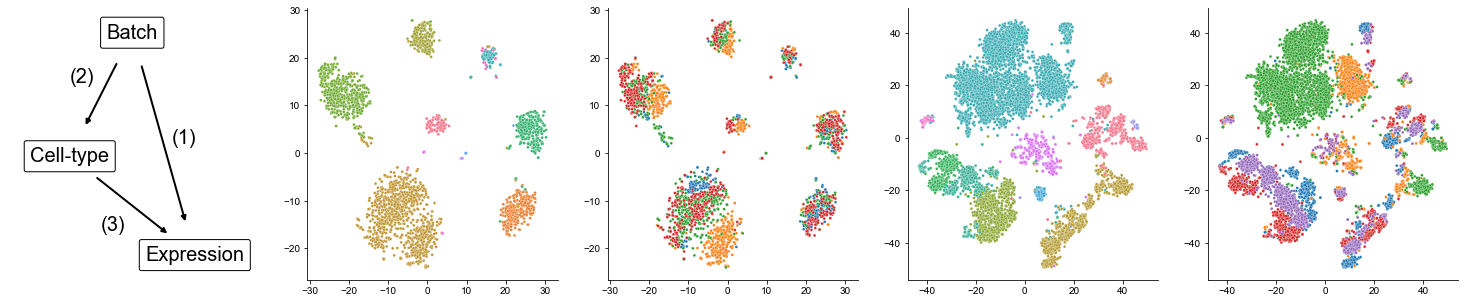

In [23]:
fig, axes = plt.subplots(1,5, figsize=(26,5))

confounder_plot(axes[0])
lower_two(axes[1], muraro)
lower_three(axes[2], muraro)
lower_two(axes[3], macparland)
lower_three(axes[4], macparland)